# Water Management Model Notebook
This notebook demonstrates a machine learning model to predict water usage and control motors based on forecasted needs.

## Importing Required Libraries

In [99]:
import logging
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from datetime import datetime

## Load Data Function

In [100]:
def load_data(file_path):
    """Load dataset from a CSV file."""
    return pd.read_csv(file_path)

## Create Sequences Function

In [101]:
def create_sequences(data, time_steps=24):
    sequences, targets = [], []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
        targets.append(data[i + time_steps])
    return np.array(sequences), np.array(targets)

## Build CNN Model Function

In [102]:
def build_cnn_model(input_shape):
    """Build a 1D CNN model for water usage prediction."""
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## Train CNN Model Function

In [103]:
def train_cnn_model(X_train, y_train, X_test, y_test):
    cnn_model = build_cnn_model((X_train.shape[1], 1))
    history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
    return cnn_model, history

## Train Other Models Function

In [104]:
def train_other_models(X_train, y_train):
    # Reshape X_train to 2D for compatibility with the other models
    X_train_2d = X_train.reshape(X_train.shape[0], X_train.shape[1])
    
    rf_model = RandomForestRegressor(n_estimators=100).fit(X_train_2d, y_train)
    xgb_model = XGBRegressor(n_estimators=100).fit(X_train_2d, y_train)
    
    return rf_model, xgb_model

## Ensemble Predictions Function

In [105]:
def ensemble_predictions(cnn_model, rf_model, xgb_model, X_test):
    cnn_preds = cnn_model.predict(X_test).flatten()
    rf_preds = rf_model.predict(X_test)
    xgb_preds = xgb_model.predict(X_test)
    return np.column_stack((cnn_preds, rf_preds, xgb_preds))

## Final Model Training Function

In [106]:
def train_final_model(stacked_features, y_test):
    final_model = LinearRegression().fit(stacked_features, y_test)
    return final_model

## Model Evaluation Function

In [107]:
def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} - MSE: {mse:.2f}, MAE: {mae:.2f}")
    return mse, mae

In [108]:
def plot_training_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('CNN Model Training Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [109]:
# Enhanced plot_data function with markers and gridlines
def plot_data(data):
    plt.figure(figsize=(14, 7))
    
    # Plotting the water usage data
    plt.plot(data['timestamp'], data['water_usage'], 
             label='Water Usage (%)', 
             color='blue', 
             marker='o', 
             linestyle='-', 
             markersize=4)
    
    # Setting the labels and title
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Water Usage (%)', fontsize=14)
    plt.title('Water Usage Over Time', fontsize=16)
    
    # Enhancing grid visibility
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Formatting the x-axis for better date representation
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    
    # Adding a legend
    plt.legend(fontsize=12, loc='upper left')
    
    # Adding a tight layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()



In [110]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label='Actual Water Usage', color='blue')
    plt.plot(y_pred, label='Predicted Water Usage', color='orange')
    plt.xlabel('Samples')
    plt.ylabel('Water Usage (%)')
    plt.title('Actual vs. Predicted Water Usage')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Main Execution

In [111]:
# Load and prepare data
data = load_data('dataset2.csv')
data.head()
if 'water_usage' not in data.columns:
    raise ValueError("The dataset must contain a 'water_usage' column.")








# Evaluate ensemble
ensemble_mae = mean_absolute_error(y_test, ensemble_preds)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_preds))
metrics['Ensemble'] = {'MAE': ensemble_mae, 'RMSE': ensemble_rmse}
evaluate_model('Ensemble', y_test, ensemble_preds)

# Create a results DataFrame
results_df = pd.DataFrame(metrics).T
print(results_df)

# Improved Training Loss Visualization
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
# If you have validation data, you could plot validation loss too:
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--', linewidth=2)
plt.title('CNN Training Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Improved Actual vs. Predicted Values Plot
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='True Values', alpha=0.7, color='black', linewidth=1.5)
plt.plot(cnn_preds, label='CNN Predictions', alpha=0.7, color='blue', linewidth=1.5)
plt.plot(rf_preds, label='Random Forest Predictions', alpha=0.7, color='green', linewidth=1.5)
plt.plot(xgb_preds, label='XGBoost Predictions', alpha=0.7, color='orange', linewidth=1.5)
plt.plot(ensemble_preds, label='Ensemble Predictions', color='red', linewidth=2.5)

plt.title('Model Predictions vs. True Values', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Water Usage', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=np.mean(y_test), color='gray', linestyle='--', label='Mean Water Usage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Improved Bar Chart for Evaluation Metrics
metrics_df = pd.DataFrame(metrics).T

plt.figure(figsize=(10, 6))
metrics_df.plot(kind='bar', color=['blue', 'orange'], alpha=0.8, edgecolor='black', legend=False)
plt.title('Model Evaluation Metrics', fontsize=16)
plt.ylabel('Error', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add value labels above the bars
for index, value in enumerate(metrics_df['MAE']):
    plt.text(index, value + 0.01, f'{value:.2f}', ha='center', fontsize=10)

for index, value in enumerate(metrics_df['RMSE']):
    plt.text(index + 0.2, value + 0.01, f'{value:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


# Improved Ensemble Predictions vs. True Values
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='True Values', color='black', alpha=0.7, linewidth=1.5)
plt.plot(ensemble_preds, label='Ensemble Predictions', color='red', linewidth=2)

# Adding fill to show error margin
plt.fill_between(range(len(y_test)), y_test, ensemble_preds, color='gray', alpha=0.3)
plt.title('Ensemble Predictions vs. True Values', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Water Usage', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=np.mean(y_test), color='blue', linestyle='--', label='Mean Water Usage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
sequences, targets = create_sequences(data['water_usage'].values)
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:

# Train individual models
cnn_model, history = train_cnn_model(X_train, y_train, X_test, y_test)
rf_model, xgb_model = train_other_models(X_train, y_train)

In [ ]:
# Get predictions
cnn_preds = cnn_model.predict(X_test).flatten()
rf_preds = rf_model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1]))
xgb_preds = xgb_model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1]))

In [ ]:

# Evaluate individual models
metrics = {}
for model_name, preds in zip(['CNN', 'Random Forest', 'XGBoost'], [cnn_preds, rf_preds, xgb_preds]):
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    metrics[model_name] = {'MAE': mae, 'RMSE': rmse}
    evaluate_model(model_name, y_test, preds)

In [ ]:

# Ensemble predictions
stacked_features = np.column_stack((cnn_preds, rf_preds, xgb_preds))
final_model = train_final_model(stacked_features, y_test)
ensemble_preds = final_model.predict(stacked_features)

### Execute Main Function

             timestamp  house_id  water_level  power_consumption  pump_status  \
0  2024-10-01 00:00:00         1    41.661634                 27            1   
1  2024-10-01 01:00:00         1    43.600320                 25            0   
2  2024-10-01 02:00:00         1    33.538872                 46            0   
3  2024-10-01 03:00:00         1    50.000000                 32            0   
4  2024-10-01 04:00:00         1    42.177533                 27            1   

   electricity_cost  water_usage  
0             15.41        32.17  
1             12.19        38.41  
2             14.66        36.75  
3             17.01        37.23  
4             16.95        34.74  
Epoch 1/50


c:\Projects\Water-consumption-Analysis\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 72.9855 - val_loss: 8.4254
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.0304 - val_loss: 8.5919
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.7018 - val_loss: 10.6303
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.5071 - val_loss: 8.5628
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.6704 - val_loss: 8.9323
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.6719 - val_loss: 10.2734
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.4180 - val_loss: 8.6584
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.6684 - val_loss: 11.1568
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.4493 - val_loss: 9.7516
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.9245 - val_loss: 8.3012
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 19.5721 - val_loss: 8.3060
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.0302 - va

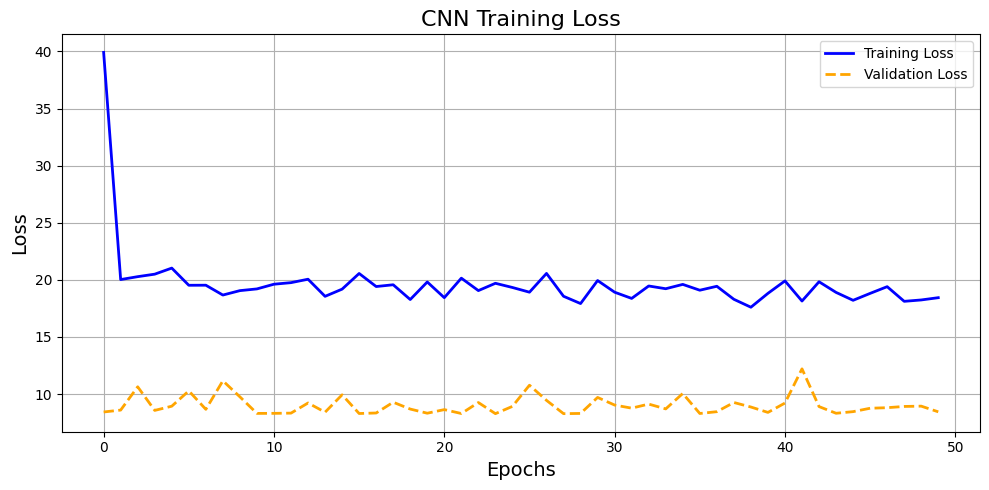

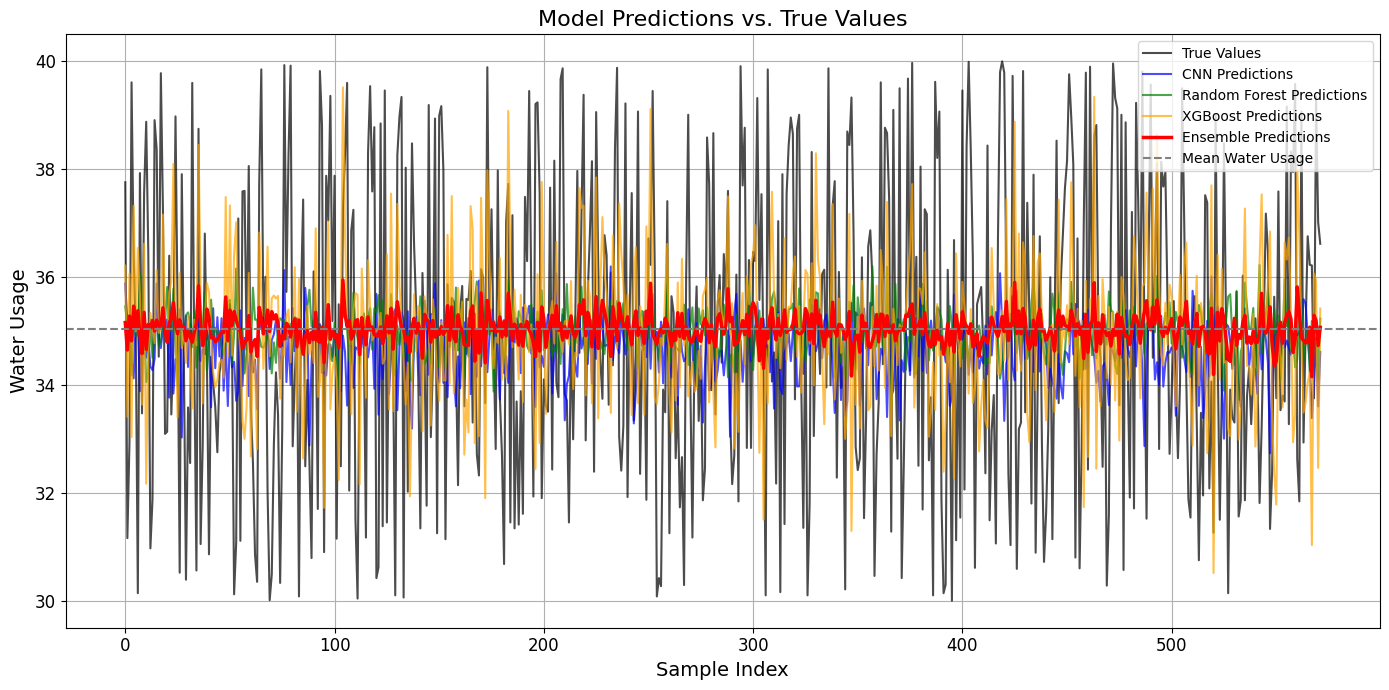

<Figure size 1000x600 with 0 Axes>

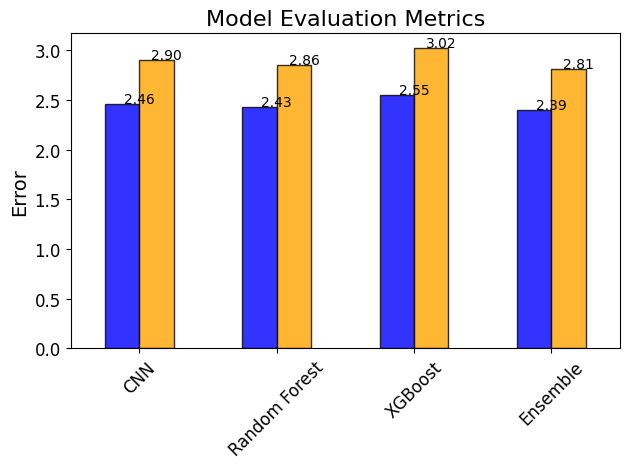

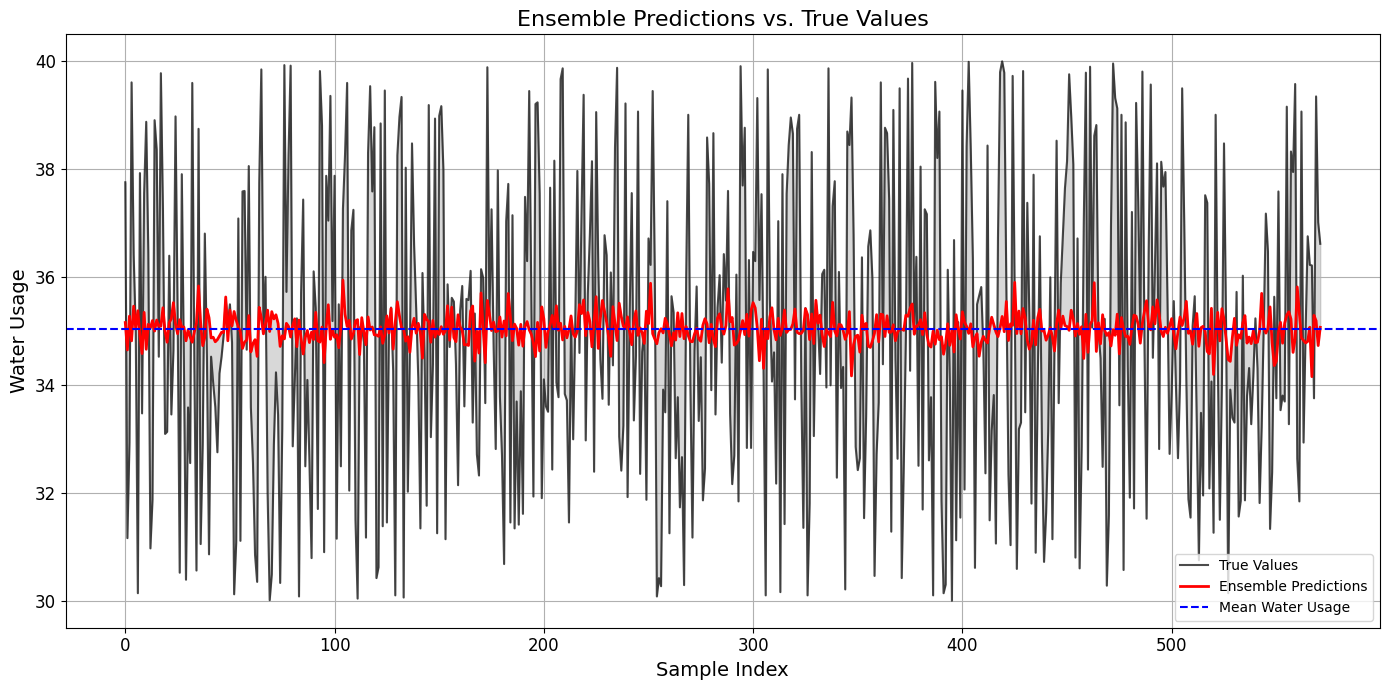